In [1]:
#loads data from csv files into the database
#also creates table admissions_cad, which has hospital admission ids of all cad patients.
#is based on admissions table, with which we can get patient id

import duckdb
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
con = duckdb.connect("cad_mimic.db")


In [3]:
# Load CSVs into DuckDB tables
con.execute("CREATE OR REPLACE TABLE patients AS SELECT * FROM read_csv_auto('../datasets/mimic-iv-3.1/mimic-iv-3.1/hosp/patients/patients.csv')")
con.execute("CREATE OR REPLACE TABLE admissions AS SELECT * FROM read_csv_auto('../datasets/mimic-iv-3.1/mimic-iv-3.1/hosp/admissions/admissions.csv')")
con.execute("CREATE OR REPLACE TABLE diagnoses_icd AS SELECT * FROM read_csv_auto('../datasets/mimic-iv-3.1/mimic-iv-3.1/hosp/diagnoses_icd/diagnoses_icd.csv')")
con.execute("CREATE OR REPLACE TABLE icd_diagnoses AS SELECT * FROM read_csv_auto('../datasets/mimic-iv-3.1/mimic-iv-3.1/hosp/d_icd_diagnoses/d_icd_diagnoses.csv')")
con.execute("""
    CREATE OR REPLACE TABLE labevents AS 
    SELECT * FROM read_csv_auto('../datasets/mimic-iv-3.1/mimic-iv-3.1/hosp/labevents/labevents.csv', ignore_errors=true)
""")
con.execute("CREATE OR REPLACE TABLE d_labitems AS SELECT * FROM read_csv_auto('../datasets/mimic-iv-3.1/mimic-iv-3.1/hosp/d_labitems/d_labitems.csv')")

print("Tables loaded successfully!")

Tables loaded successfully!


In [4]:
# Step 1: CAD-positive admissions
cad_hadm_query = """
    SELECT DISTINCT hadm_id
    FROM diagnoses_icd
    WHERE
        (icd_version = '10' AND icd_code IN (
            'I200','I201','I208','I209',
            'I210','I211','I212','I213','I214','I219',
            'I220','I221','I222','I228','I229',
            'I250','I251','I252','I253','I254','I255','I256','I257','I258','I259',
            'I256', 'I258', 'I259'
        ))
        OR
        (icd_version = '9' AND icd_code IN (
            '41000','41001','41002','41010','41011','41012','41020','41021','41022',
            '41030','41031','41032','41040','41041','41042','41050','41051','41052',
            '41060','41061','41062','41070','41071','41072','41080','41081','41082',
            '41090','41091','41092',
            '4110','4111','4118',
            '412',
            '4130','4131','4139',
            '41400','41401','41402','41403','41404',
            '4142','4143','4144','4148','4149'
        ))
"""
cad_hadm_ids = con.execute(cad_hadm_query).df()

In [ ]:
# con.execute("DROP TABLE IF EXISTS admissions_cad")
# con.close()


In [5]:
# Step 2: Create admissions_cad table with specified columns
#Contains patients with and without cad, classified based on ICD codes


con.execute("""
    CREATE OR REPLACE TABLE admissions_cad AS
    SELECT 
        a.hadm_id,
        p.subject_id AS patientid,
        p.gender,
        p.anchor_age,
        p.anchor_year,
        p.anchor_year_group,
        p.dod,
        CASE 
            WHEN d.hadm_id IS NOT NULL THEN 1 
            ELSE 0 
        END AS cad
    FROM admissions a
    JOIN patients p 
        ON a.subject_id = p.subject_id
    LEFT JOIN (
        SELECT DISTINCT hadm_id
        FROM diagnoses_icd
        WHERE
            (icd_version = '10' AND icd_code IN (
                'I200','I201','I208','I209',
                'I210','I211','I212','I213','I214','I219',
                'I220','I221','I222','I228','I229',
                'I250','I251','I252','I253','I254','I255','I256','I257','I258','I259',
                '41000','41001','41002','41010','41011','41012','41020','41021','41022',
                '41030','41031','41032','41040','41041','41042','41050','41051','41052',
                '41060','41061','41062','41070','41071','41072','41080','41081','41082',
                '41090','41091','41092',
                '4110','4111','4118',
                '412',
                '4130','4131','4139',
                '41400','41401','41402','41403','41404',
                '4142','4143','4144','4148','4149'
            ))
            OR
            (icd_version = '9' AND icd_code IN (
                '41000','41001','41002','41010','41011','41012','41020','41021','41022',
                '41030','41031','41032','41040','41041','41042','41050','41051','41052',
                '41060','41061','41062','41070','41071','41072','41080','41081','41082',
                '41090','41091','41092',
                '4110','4111','4118',
                '412',
                '4130','4131','4139',
                '41400','41401','41402','41403','41404',
                '4142','4143','4144','4148','4149'
            ))
    ) d ON a.hadm_id = d.hadm_id
""")


In [6]:
# Step 3: Most common lab tests for CAD admissions
common_tests_query = """
    SELECT d.label, COUNT(*) as frequency
    FROM labevents l
    JOIN d_labitems d ON l.itemid = d.itemid
    WHERE l.hadm_id IN (SELECT hadm_id FROM admissions_cad WHERE cad = 1)
    GROUP BY d.label
    ORDER BY frequency DESC
    LIMIT 10
"""
common_tests = con.execute(common_tests_query).df()
print("Most Common Blood Tests for CAD Admissions:\n", common_tests)


Most Common Blood Tests for CAD Admissions:
            label  frequency
0        Glucose     599759
1      Potassium     516209
2         Sodium     503598
3       Chloride     502011
4     Creatinine     494479
5  Urea Nitrogen     492107
6     Hemoglobin     489397
7     Hematocrit     484925
8    Bicarbonate     481709
9      Anion Gap     479560


In [7]:
# Step 4: Significant lab value differences
significant_tests_query = """
    SELECT d.label,
           AVG(CASE WHEN l.hadm_id IN (SELECT hadm_id FROM admissions_cad WHERE cad = 1) THEN l.valuenum END) AS avg_cad,
           AVG(CASE WHEN l.hadm_id NOT IN (SELECT hadm_id FROM admissions_cad WHERE cad = 1) THEN l.valuenum END) AS avg_non_cad
    FROM labevents l
    JOIN d_labitems d ON l.itemid = d.itemid
    WHERE l.valuenum IS NOT NULL
    GROUP BY d.label
    ORDER BY ABS(avg_cad - avg_non_cad) DESC
    LIMIT 10
"""
significant_tests = con.execute(significant_tests_query).df()
print("Significant Differences in Lab Values (CAD vs Non-CAD Admissions):\n", significant_tests)


Significant Differences in Lab Values (CAD vs Non-CAD Admissions):
                           label        avg_cad   avg_non_cad
0                          HPE8       5.622222  46951.755118
1              RBC, Other Fluid   22635.338068  67820.200000
2               Lipase, Ascites   35986.250000  11509.050420
3        Miscellaneous, Pleural   20211.000000   1289.833333
4              RBC, Joint Fluid  111745.115265  98948.134256
5                          PAN3      50.000000  11822.266667
6                Amylase, Urine   23735.750000  13162.925373
7            Lipase, Body Fluid    7131.000000  16100.622222
8               proBNP, Pleural   11448.485088   4741.618890
9  Human Chorionic Gonadotropin   16494.400000  22872.059172


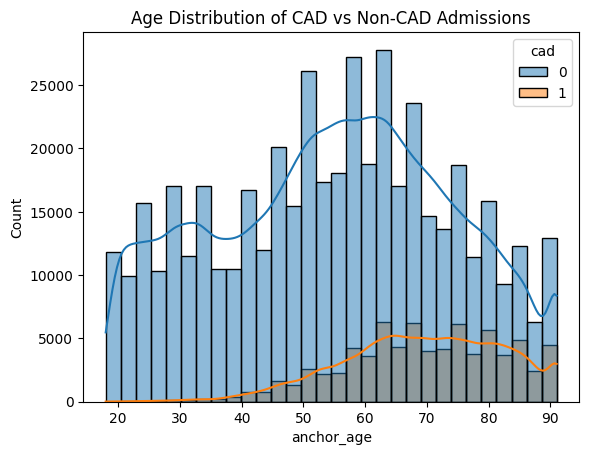

In [9]:
# Step 5: Plot age distribution (based on patients table linked by hadm_id)
df_plot = con.execute("""
    SELECT p.anchor_age, ac.cad
    FROM admissions_cad ac
    JOIN patients p ON ac.patientid = p.subject_id
""").df()

sns.histplot(data=df_plot, x="anchor_age", hue="cad", bins=30, kde=True)
plt.title("Age Distribution of CAD vs Non-CAD Admissions")
plt.show()


In [ ]:
con.close()